<a href="https://colab.research.google.com/github/andresmoreno923/NumpySocket/blob/main/ES_Mentoria_SAMGEO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segment Anything

El Segment Anything Model (SAM) produce máscaras de objetos de alta calidad a partir de indicaciones de entrada, como puntos o cuadros, y se puede utilizar para generar máscaras para todos los objetos de una imagen. Ha sido entrenado en un conjunto de datos de 11 millones de imágenes y 1100 millones de máscaras, y tiene un sólido rendimiento de disparo cero en una variedad de tareas de segmentación.

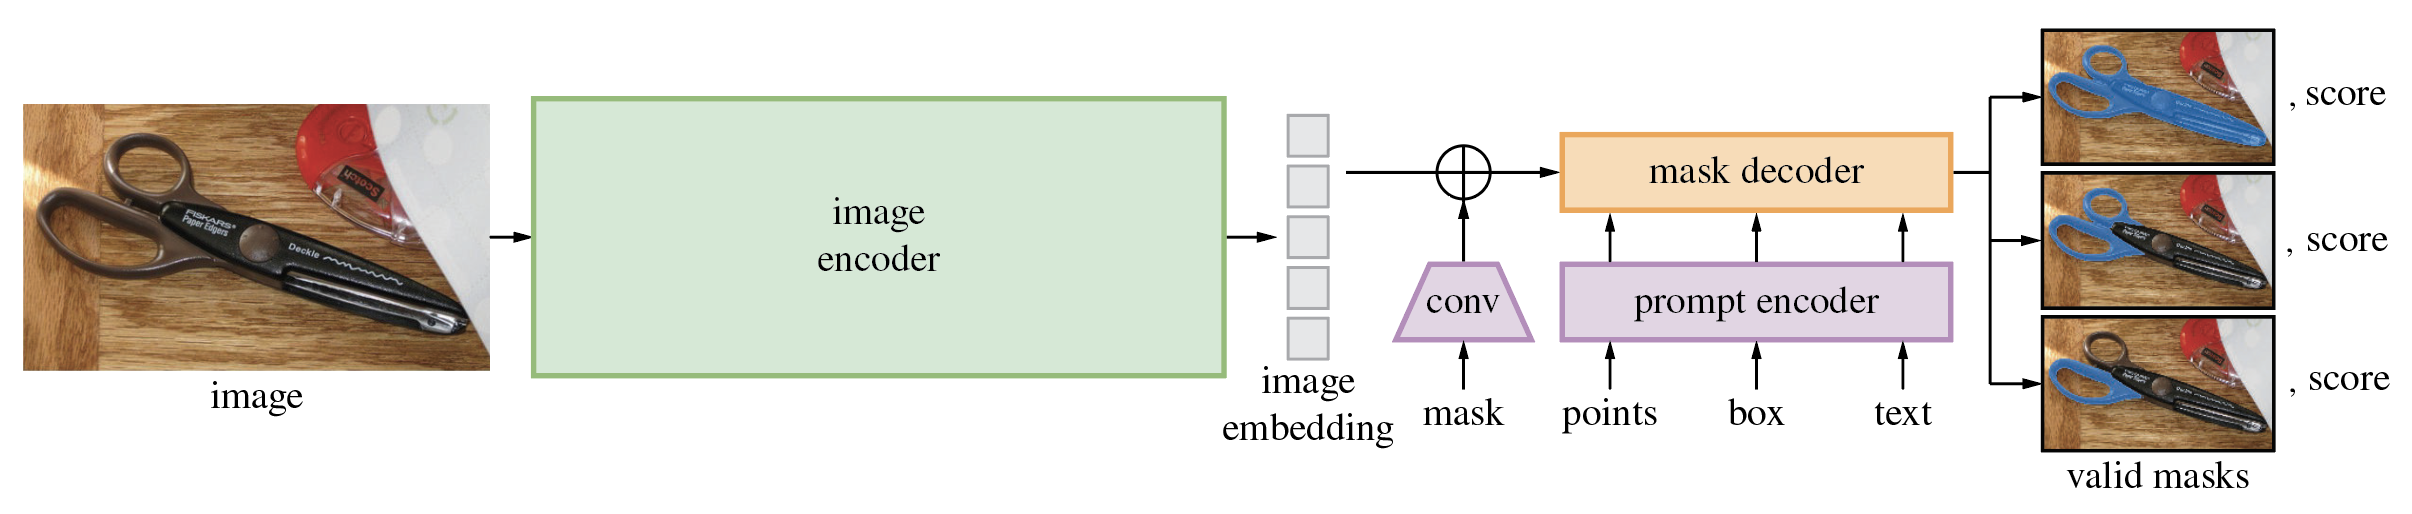

## SAMGEO

Una Biblioteca de Python para segmentar datos geoespaciales con Segment Anything Model (SAM)

El paquete segment-geospatial se inspira en el repositorio segment-anything-eo creado por Aliaksandr Hancharenka. Para facilitar el uso de Segment Anything Model (SAM) para datos geoespaciales, he desarrollado los paquetes de Python segment-anything-py y segment-geospatial, que ahora están disponibles en PyPI y conda-forge. Mi objetivo principal es simplificar el proceso de aprovechamiento de SAM para el análisis de datos geoespaciales al permitir que los usuarios lo logren con un mínimo esfuerzo de codificación. He adaptado el código fuente de segment-geospatial del repositorio segment-anything-eo, y el crédito por su versión original es para Aliaksandr Hancharenka.

Free software: MIT license

Documentation: https://samgeo.gishub.org

Asegúrese de usar el tiempo de ejecución de GPU para esta computadora portátil. Para Google Colab, vaya a `Editar` -> `Configuración` y seleccione `GPU` como acelerador de hardware.

Instalemos las bibliotecas necesarias:

In [ ]:
!pip install segment-geospatial leafmap localtileserver
!pip install rasterio
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 104.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 100.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

Nos conectamos al Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Definimos la ruta de nuestra imagen de prueba:

In [ ]:
path = '/content/drive/MyDrive/California_NAIP.tif'

Realizaremos las importaciones de funciones y módulos que serán utilizados:

In [ ]:
import os
import leafmap
import torch
from samgeo import SamGeo, tms_to_geotiff, get_basemaps
import rasterio
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

Importemos ahora la imagen usando raster y visualizamos con matplotlib:

In [ ]:
src = rasterio.open(path)

In [ ]:
img = src.read()

In [ ]:
img.shape

(3, 6535, 13416)

In [ ]:
img = img.transpose([1,2,0])

In [ ]:
img = img.astype('uint8')

(-0.5, 13415.5, 6534.5, -0.5)

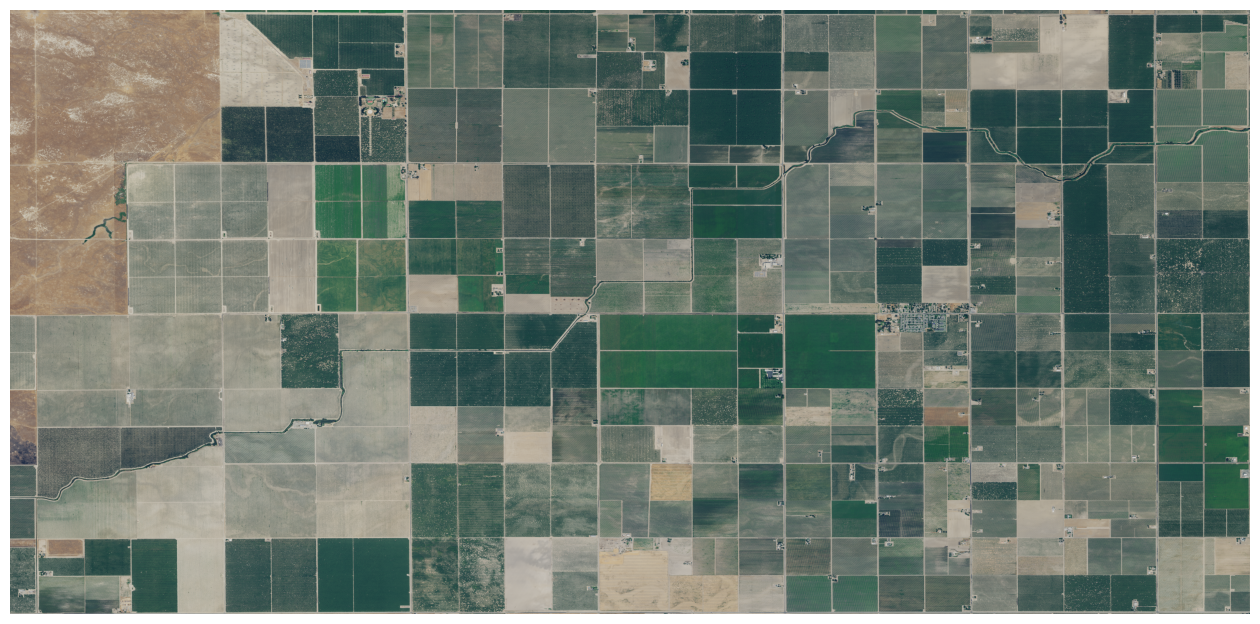

In [ ]:
plt.figure(figsize=[16,16])
plt.imshow(img)
plt.axis('off')

Como es una imagen de alta resolución con una gran cantidad de píxeles, reduzcamos el tamaño de la imagen a la mitad usando el rasterio:

In [ ]:
from rasterio.enums import Resampling
from rasterio.plot import show

In [ ]:
donwscale_factor = 2
with rasterio.open(path) as dataset:
  data = dataset.read(out_shape=(dataset.count,int(dataset.height / donwscale_factor), int(dataset.width / donwscale_factor)),resampling=Resampling.bilinear)
  transform = dataset.transform * dataset.transform.scale((dataset.width / data.shape[-1]),(dataset.height / data.shape[-2]))
  profile = dataset.profile

profile.update(transform=transform, driver='GTiff', height=data.shape[-2], width=data.shape[-1], crs=dataset.crs, compress='lzw', dtype='uint8')
with rasterio.open(os.path.join('/content/RGB_resampled.tif'),'w', **profile) as dst:
  dst.write(data)

Por lo tanto, podemos descargar los pesos e instanciar el modelo:

In [ ]:
out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
checkpoint = os.path.join(out_dir, 'sam_vit_h_4b8939.pth')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sam = SamGeo(
    checkpoint=checkpoint,
    model_type='vit_h',
    device=device,
    erosion_kernel=(3, 3),
    mask_multiplier=255,
    sam_kwargs=None,
)

Checkpoint /root/Downloads/sam_vit_h_4b8939.pth does not exist.


Downloading...
From: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
To: /root/Downloads/sam_vit_h_4b8939.pth
100%|██████████| 2.56G/2.56G [00:15<00:00, 163MB/s]


Con la imagen que redujimos de tamaño, apliquemos la segmentación:

In [ ]:
image = '/content/RGB_resampled.tif'

In [ ]:
mask = 'segment.tiff'
sam.generate(image, mask)

100%|██████████| 98/98 [04:41<00:00,  2.88s/it]


Con la máscara resultante, la convertimos en un

In [ ]:
if not os.path.isdir('/content/Result'):
    os.mkdir('/content/Result')

In [ ]:
shapefile = '/content/Result/segment.shp'
sam.tiff_to_vector(mask, shapefile)

Con el proceso finalizado, visualicemos el shapefile resultante con la imagen:

In [ ]:
src_test = rasterio.open(image)

In [ ]:
mask_result = gpd.read_file(shapefile)

<Axes: >

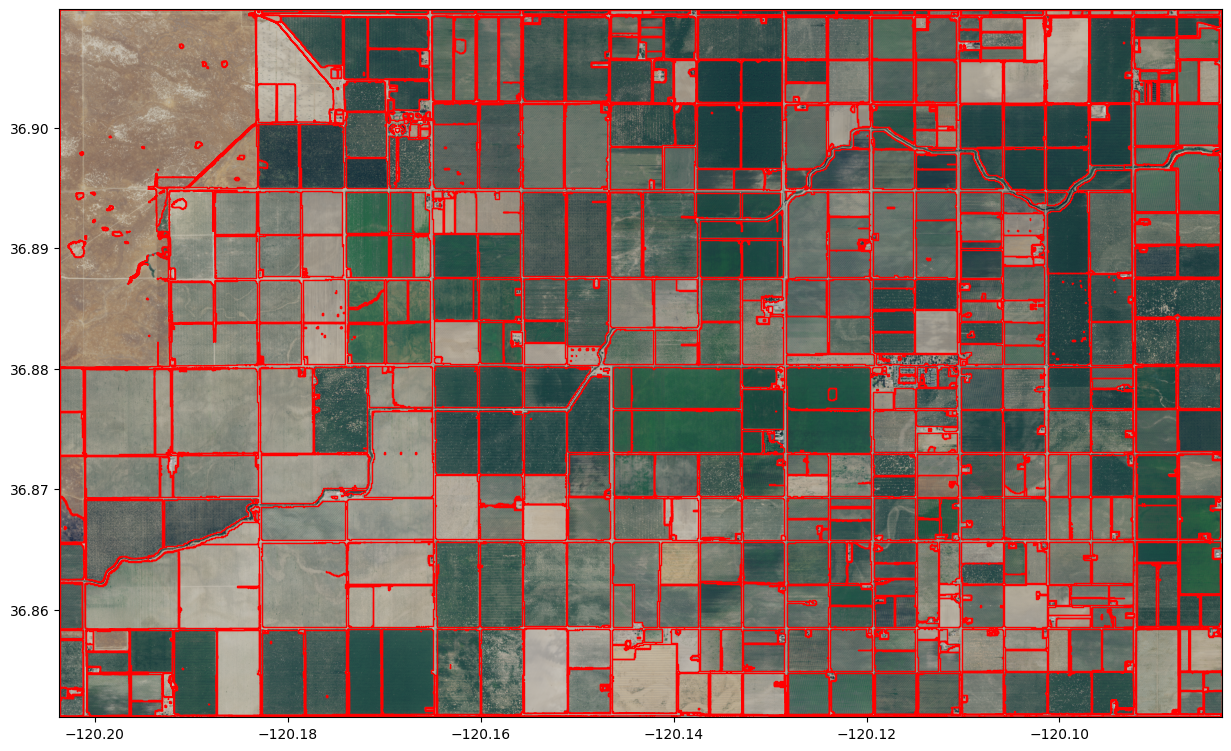

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(src_test, ax=ax)
mask_result.plot(ax=ax, facecolor='none', edgecolor='red')

También es posible trazar los polígonos con colores aleatorios:

In [ ]:
random_id = np.random.randint(low=0, high=len(mask_result), size=(len(mask_result)))
mask_result['id'] = random_id

<Axes: >

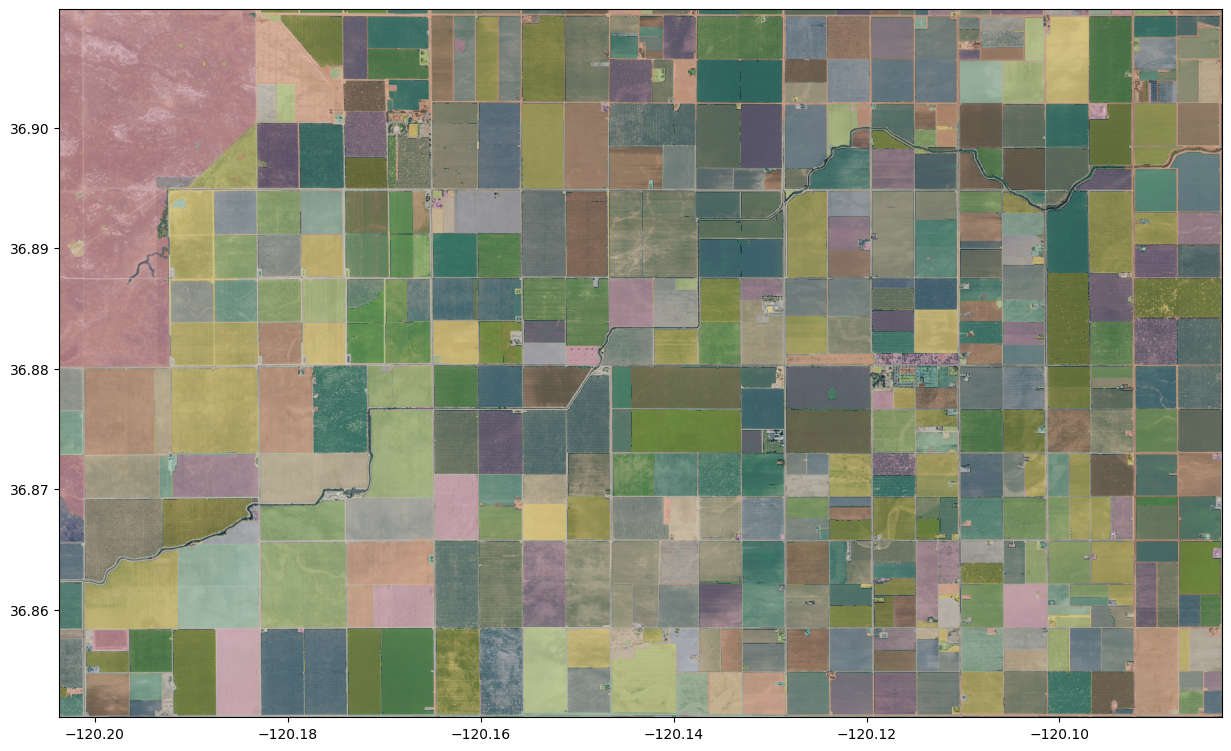

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(src_test, ax=ax)
mask_result.plot(ax=ax, column = 'id', cmap='Set2', alpha=0.3)


Finalmente, podemos descargar los resultados:

In [ ]:
!zip -r /content/Result.zip /content/Result
from google.colab import files
files.download("/content/Result.zip")

  adding: content/Result/ (stored 0%)
  adding: content/Result/segment.prj (deflated 17%)
  adding: content/Result/segment.shx (deflated 55%)
  adding: content/Result/segment.dbf (deflated 100%)
  adding: content/Result/segment.shp (deflated 76%)
  adding: content/Result/segment.cpg (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### ***Si estás interesado en conocer más sobre el mundo de la Inteligencia Artificial aplicada a imágenes de Drones y Satélites, ha llegado el momento de participar de nuestra Mentoria.***



***ESTÁ ABIERTA LA INSCRIPCIÓN PARA LA CUARTA CLASE DE CAPACITACIÓN EN VISIÓN COMPUTACIONAL Y DEEP LEARNING PARA IMÁGENES DE DRONES E SATÉLITES***

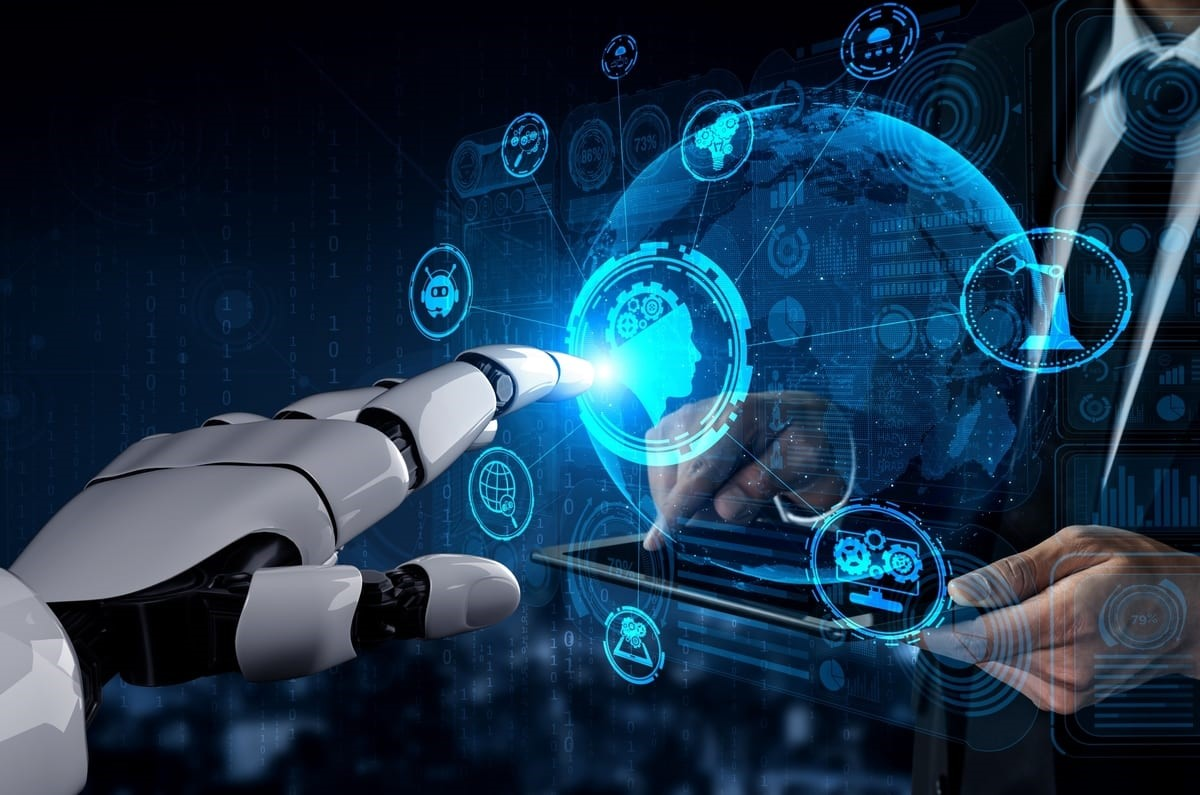

Con solo un conocimiento básico de programación python y GIS en un ENTORNO LIBRE DE COMPUTACIÓN EN LA NUBE, implementaremos y entrenaremos modelos de IA para tareas como detección, clasificación y segmentación de imágenes de drones y satélites, con casos de uso en varias áreas como:

✔ Agricultura de precisión 🚜

✔ Análisis ambiental 🌏

✔ Análisis Urbano 🏙

✔ Minería ⛏

✔ Energias renovables ⚡

✔ Área forestal 🌲

✔ Geomarketing 🗺

✔ Cualquier otra área que necesite extraer información de las imágenes.

Contenido: https://lnkd.in/dmS6RWdD

Contamos con un Grupo de Whatsapp de la Mentoría para consultas e intercambio de experiencias.

Información:

🗓 22/05, 29/05, 05/06, 12/06

⌚ 8pm – Chile, Argentina, Paraguai, Uruguai

⌚ 7pm – Bolivia

⌚ 6pm – Peru, Ecuador, Colombia

⌚ 5pm – Mexico, Am. Central


⌛ Unas 2 horas por Meet.

🎥 Los Meets serán grabadas y estarán disponibles.

💵 174 USD – PayPal, Western Union, Nomad, Payoneer

📜 Emitiremos Certificado!


Los interesados ​​pueden contactarnos por correo: joaootavionf007@gmail.com 

O por linkedin: https://www.linkedin.com/in/jo%C3%A3o-otavio-firigato-4876b3aa/

Gracias!